In [1]:
import os
import sys
import cv2
import torch

import numpy as np
import albumentations as album
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from torchmetrics import JaccardIndex

sys.path.insert(0, '..')
from loaders.datasets import AmsterdamDataset
from utils.general import visualize
from utils.augmentation import *
from utils.metrics import BlobOverlap

In [2]:
preprocessing_fn = smp.encoders.get_preprocessing_fn('efficientnet-b3', 'imagenet')
model = torch.load(os.path.join('..', 'experiments', 'effnetb3-unetpp-1000s-aug', 'best_model.pth'))

images = os.path.join('..', 'data', 'images')
annotations = os.path.join('..', 'data', 'fences-quays', 'annotations', 'train-annotations-6px.json')

data = AmsterdamDataset(images, annotations, preprocessing=get_preprocessing(None), train=False)

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


0
2021-02-04-TMX7316010203-001991-pano_0000_000055-r.jpg


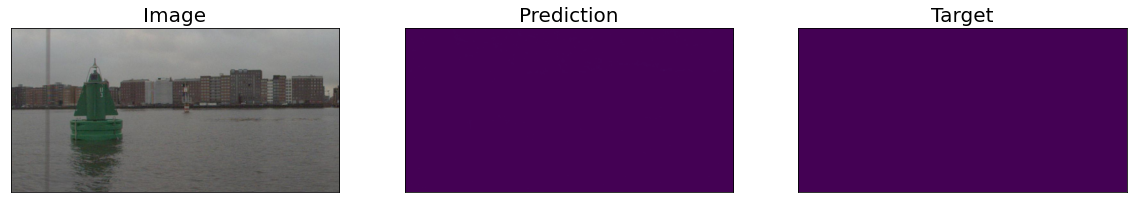

iou: tensor([1., 1.])

1
2021-02-04-TMX7316010203-001991-pano_0000_000042-r.jpg


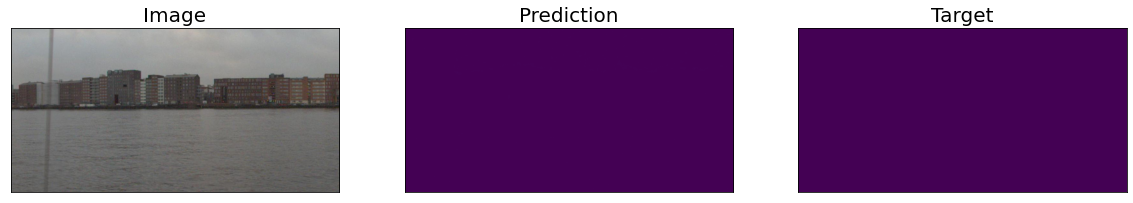

iou: tensor([1., 1.])

2
2021-02-04-TMX7316010203-001991-pano_0000_000039-l.jpg


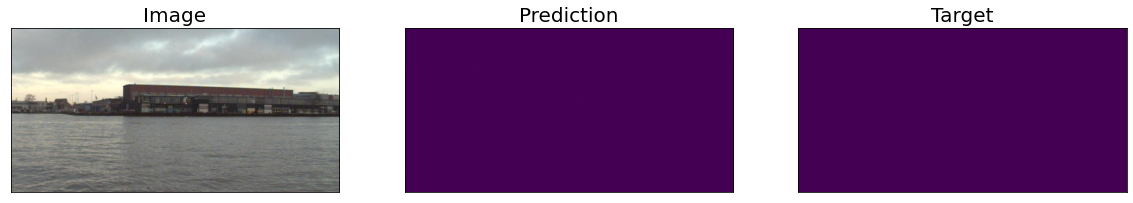

iou: tensor([1., 1.])

3
2021-02-04-TMX7316010203-001991-pano_0000_000037-r.jpg


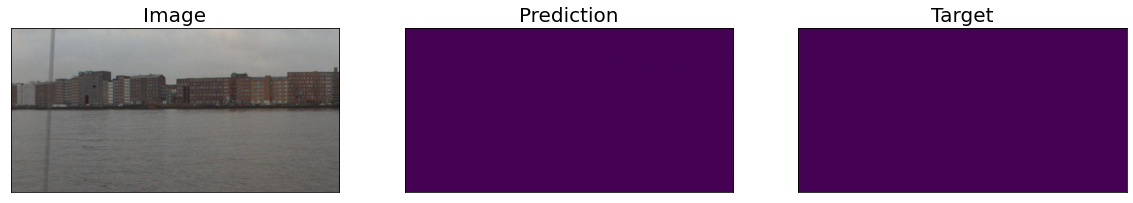

iou: tensor([1., 1.])

4
2021-02-04-TMX7316010203-001991-pano_0000_000017-r.jpg


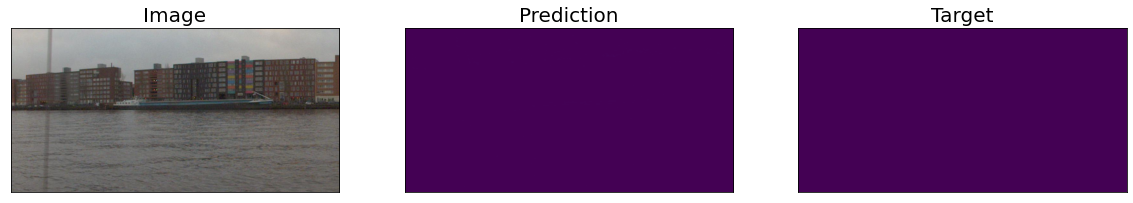

iou: tensor([1., 1.])

5
2021-02-04-TMX7316010203-001991-pano_0000_000012-r.jpg


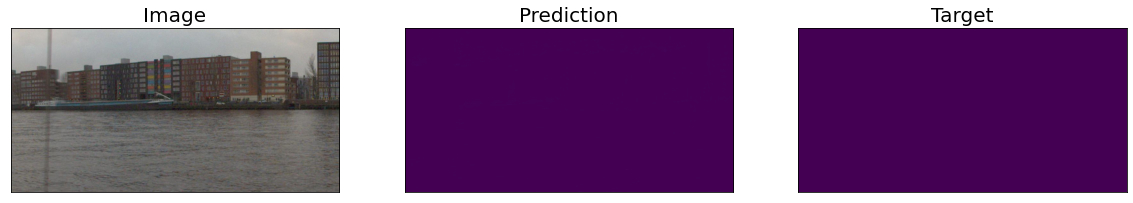

iou: tensor([1., 1.])

6
2021-01-27-TMX7316010203-001986-pano_0000_000923-r.jpg


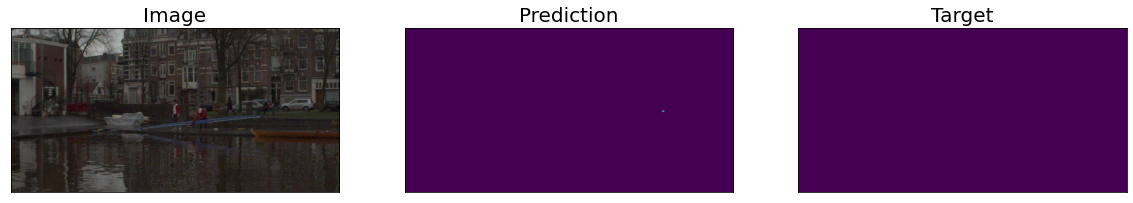

iou: tensor([1.0000, 0.0000])

tensor([1.0000, 0.8571])


NameError: name 'BO' is not defined

In [3]:
%matplotlib inline

miou = 0
IoU = JaccardIndex(num_classes=2, reduction='none', absent_score=1)
# BO = BlobOverlap()

for i, (image, mask) in enumerate(data):
    print(i)
    img = plt.imread(os.path.join(images, data.images[i]['file_name']))
    
    print(data.images[i]['file_name'])
    
    mask = np.squeeze(mask)
    x = torch.as_tensor(image).unsqueeze(0).cuda()
    
    with torch.no_grad():
        pred = model(x)
    
    visualize(image=img,
              prediction=pred.squeeze().cpu(),
              target=mask)
    
    iou = IoU(pred.cpu(), torch.as_tensor(mask).unsqueeze(0).int())

#     print('blob-iou:', BO.update(pred, torch.as_tensor(mask).unsqueeze(0)))
    print('iou:', iou)
    
    miou += iou
    
    print()
    
    if i > 5:
        break
    
print(miou / (i + 1))
BO.compute()

In [ ]:
prediction = pred.squeeze().cpu().numpy() > .5
target = mask.copy()

target[np.where(target == 0)] = -1
diff = target - prediction

# 0 = TP / TN
# -1 = FP
# 1 = FN
print('TP:', np.count_nonzero(diff == 0))
print('TN:', np.count_nonzero(diff == -1))
print('FP:', np.count_nonzero(diff == -2))
print('FN:', np.count_nonzero(diff == 1))



print(np.unique(diff))

visualize(difference=diff)

In [ ]:
from utils.metrics import PositiveConfusionMatrix

pcm = PositiveConfusionMatrix()

print(pcm(pred.squeeze().cpu(), torch.as_tensor(mask)))

In [ ]:
from torchmetrics import ConfusionMatrix

cm = ConfusionMatrix(num_classes=2, normalize='true')

print(np.unique(mask))
mask[mask == -1] = 0

print(cm(pred.squeeze().cpu(), torch.as_tensor(mask).int()))

In [ ]:
# TN FP
# FN TP